# Installing necessary packages

In [1]:
!pip install xgboost

## Importing necessary libraries

In [128]:
# Dataframe manupilation and analysis libraries
import pandas as pd   
import numpy as np

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# Multicollinearity test package
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preparation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV

# Feature decomposition library
from sklearn.decomposition import PCA

# Model evaluation libraries
from sklearn.metrics import r2_score, mean_squared_error

# Machine learning models
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import xgboost
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.naive_bayes import MultinomialNB,GaussianNB

# clustering library
from sklearn.cluster import KMeans

# Feature selection
from sklearn.feature_selection import RFE

# Learning curve analysis library
from sklearn.model_selection import learning_curve

# library to filter warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the Dataframe

In [3]:
df = pd.read_excel('Capstone Project.xlsx')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


## Problem Statement

* Build a machine learning model which can predict the strength of the mixture for given composition of ingredients like cement,slag,ash,water,superplastic,coarseagg,fineagg,age.

## Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Analysis:
- There are 1030 rows/records in the dataset
- There are 9 columns/features
- There are no null values present 
- All values are in the form of continuous data

#### Descriptive Analysis

In [5]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Observations:

(in ash mean > median they may be skewed)
- cement, slag, ash, age may have outliers because mean and median are not same
- slag, ash, superplastic there will be no chance of outliers in the lower whisker region as min and Q1 values are same
- cement, slag, ash, superplastic, age might have outliers in the higher whisker region.

#### Building  a custom summary function for indepth EDA report

In [6]:
def custom_summary(mydf):
    cols = []
    for i in df.columns:
        if mydf[i].dtype!=object:
            cols.append(i)
            
    result = pd.DataFrame(columns = cols,index=['datatype','count','min','Q1','Q2','Q3','max','mean','stddev',
                                                'skew','kurt','range','IQR','skew_comment','kurt_comment',
                                                'outlier_comment'])
    for i in result.columns:
        result.loc['datatype',i]=mydf[i].dtype
        result.loc['count',i] = mydf[i].count()
        result.loc['min',i] = mydf[i].min()
        result.loc['Q1',i] = mydf[i].quantile(0.25)
        result.loc['Q2',i] = mydf[i].quantile(0.5)
        result.loc['Q3',i] = mydf[i].quantile(0.75)
        result.loc['max',i] = mydf[i].quantile(1)
        result.loc['mean',i] = round(mydf[i].mean(),2)
        result.loc['stddev',i] = round(mydf[i].std(),2)
        result.loc['skew',i] = round(mydf[i].skew(),2)
        result.loc['kurt',i] = round(mydf[i].kurt(),2)
        result.loc['range',i] = mydf[i].max()-mydf[i].min()
        result.loc['IQR',i] = mydf[i].quantile(0.75)-mydf[i].quantile(0.25)
        
 # adding comments for skewness
        
        if result.loc['skew',i]<-1:
            sk_label = 'Highly negatively skewed'
        elif -1 < result.loc['skew',i] <= -0.5:
            sk_label = 'moderately negatively skewed'
        elif -0.5 < result.loc['skew',i] <= 0:  
            sk_label = 'approximately normally distributed (-ve)'
        elif 0 < result.loc['skew',i] <= 0.5:
            sk_label = 'approximately normally distributed (+ve)'
        elif 0.5 < result.loc['skew',i] <= 1:
            sk_label = ' moderately positively skewed'
        elif result.loc['skew',i] > 1:
            sk_label = 'Highly positively skewed'
        else:
            sk_label = 'error'
            
        result.loc['skew_comment',i] = sk_label
        
  # adding comments for kurtosis

        # for kurt < -1 : Highly platykurtic
        # for kurt -1 to -0.5 : moderataly platykurtic
        # for kurt -0.5 to 0.5 : mesokurtic curve
        # for kurt 0.5 to 1 : moderataly leptokurtic
        # for kurt < 1 : highly leptokurtic
        
        if result.loc['kurt',i]<-1:
            kt_label = 'Highly platykurtic'
        elif -1 < result.loc['kurt',i] <= -0.5:
            kt_label = 'moderataly platykurtic'
        elif -0.5 < result.loc['kurt',i] <= 0.5:
            kt_label = 'mesokurtic curve'
        elif 0.5 < result.loc['kurt',i] <= 1:
            kt_label = 'moderataly leptokurtic '
        elif result.loc['kurt',i] >1:
            kt_label = 'highly leptokurtic'
        else:
            kt_label = 'error'
             
        result.loc['kurt_comment',i] = kt_label
        
 # adding comments for outliers
    
        lw = result.loc['Q1',i] - (1.5 * result.loc['IQR',i])
        uw = result.loc['Q3',i] + (1.5 * result.loc['IQR',i])
        
        if len([x for x in mydf[i] if x < lw or x > uw]) > 0:
            outlier_label = 'Have Outliers'
        else:
            outlier_label = 'No Outliers'
            
        result.loc['outlier_comment', i] = outlier_label
    
    return result
        

In [7]:
custom_summary(df)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
datatype,float64,float64,float64,float64,float64,float64,float64,int64,float64
count,1030,1030,1030,1030,1030,1030,1030,1030,1030
min,102.0,0.0,0.0,121.8,0.0,801.0,594.0,1,2.33
Q1,192.375,0.0,0.0,164.9,0.0,932.0,730.95,7.0,23.71
Q2,272.9,22.0,0.0,185.0,6.4,968.0,779.5,28.0,34.445
Q3,350.0,142.95,118.3,192.0,10.2,1029.4,824.0,56.0,46.135
max,540.0,359.4,200.1,247.0,32.2,1145.0,992.6,365.0,82.6
mean,281.17,73.9,54.19,181.57,6.2,972.92,773.58,45.66,35.82
stddev,104.51,86.28,64.0,21.35,5.97,77.75,80.18,63.17,16.71
skew,0.51,0.8,0.54,0.07,0.91,-0.04,-0.25,3.27,0.42


Analysis 
1. we have outliers in slag, water, superplastic, fineagg, age and strength.

#### checking for outliers using boxplot

In [8]:
def replace_outlier(mydf,col,method = 'Quartile',strategy = 'median'):
    if method == 'Quartile':
        Q1 = mydf[col].quantile(0.25)  
        Q2 = mydf[col].quantile(0.50)
        Q3 = mydf[col].quantile(0.75)
        IQR = Q3 - Q1
        LW = Q1 - 1.5 * IQR
        UW = Q3 + 1.5 * IQR
    elif method == 'standard deviation':
        mean = mydf[col].mean()
        std = mydf[col].std()
        LW = mean - (2* std)
        UW = mean + (2* std)
    else:
        print('pass a correct method')
# printing all the outliers
    outliers = mydf.loc[(mydf[col] < LW) | (mydf[col] > UW), col]
    outliers_density = round(len(outliers)/ len(mydf),2)
    if len(outliers) == 0:
        print(f'feature {col} does not have any outliers')
    else:
        print(f'feature {col} has outliers')
        print(f'total no of outliers in {col} is {len(outliers)}')
        print(f'outlier percentage in {col} is {outliers_density * 100}%')
        
    if strategy == 'median':
    #     mydf.loc[(mydf[col] < LW),col] = Q2   # used for first method
    #     mydf.loc[(mydf[col] > UW),col] = Q2   # used for first method
        mydf.loc[(mydf[col] < LW),col] = Q1     # second method.. the data may get currupted. so we are restarting and running again here
        mydf.loc[(mydf[col] > UW),col] = Q3     # second method.. as the outliers are more and not treated fully in method 1 we are using this
    elif strategy == 'mean':
        mydf.loc[(mydf[col] < LW),col] = mean   # second method.. the data may get currupted. so we are restarting and running again here
        mydf.loc[(mydf[col] > UW),col] = mean
    else:
        print('pass the correct strategy')
    
    return mydf


In [9]:
def odt_plots(mydf,col):
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(25,8))
    # descriptive statistic boxplot
    sns.boxplot(mydf[col],ax = ax1)
    ax1.set_title(col +  ' boxplot')
    ax1.set_xlabel('values')
    ax1.set_ylabel('boxplot')
    # replacing the outliers
    mydf_out = replace_outlier(mydf,col)
    # plotting boxplot without outliers
    sns.boxplot(mydf_out[col],ax = ax2)
    ax2.set_title(col + ' boxplot')
    ax2.set_xlabel('values')
    ax2.set_ylabel('boxplot')
    plt.show()

feature cement does not have any outliers


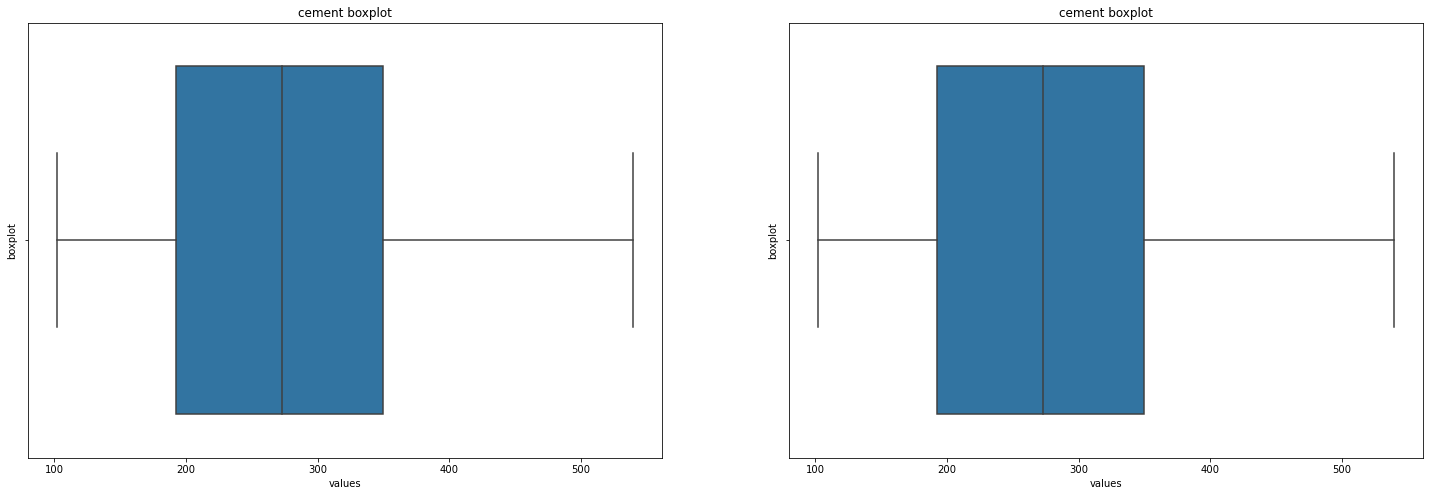

feature slag has outliers
total no of outliers in slag is 2
outlier percentage in slag is 0.0%


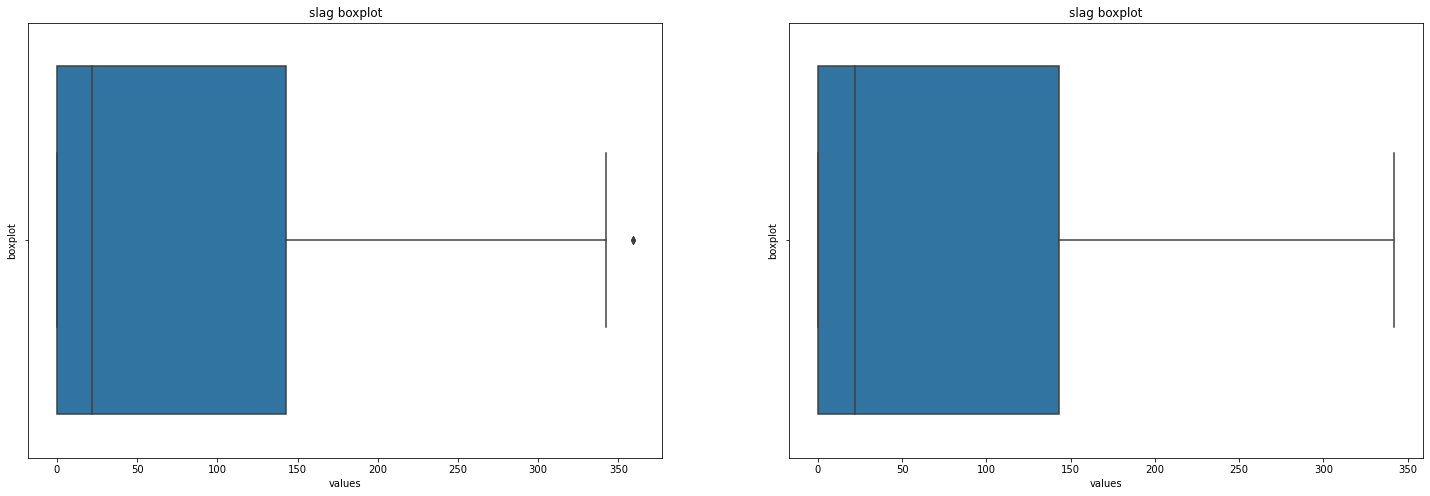

feature ash does not have any outliers


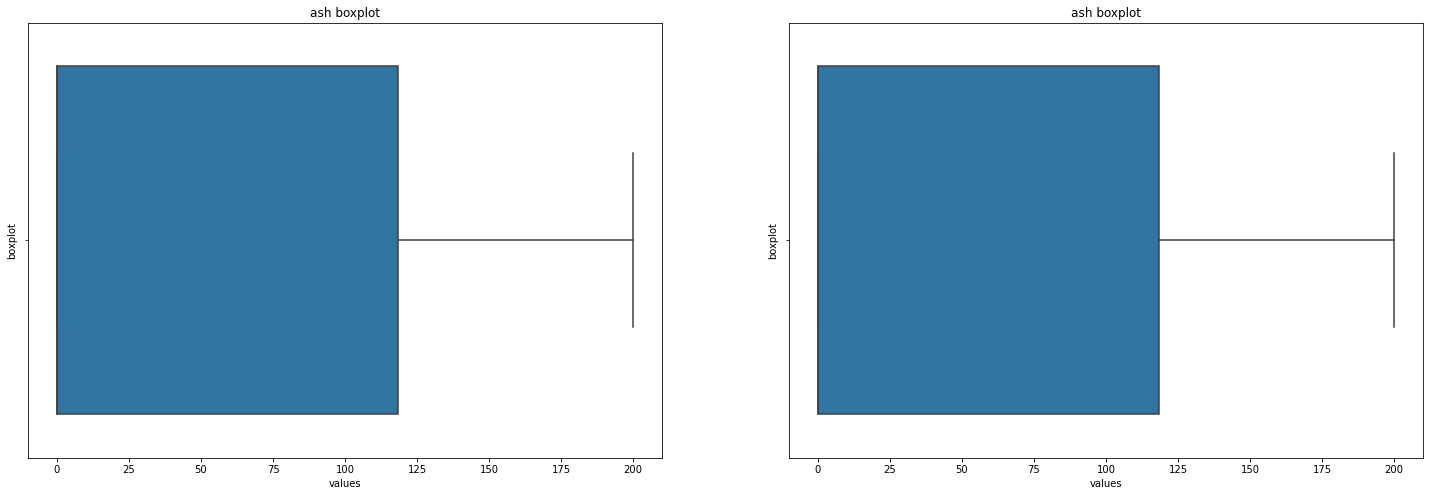

feature water has outliers
total no of outliers in water is 9
outlier percentage in water is 1.0%


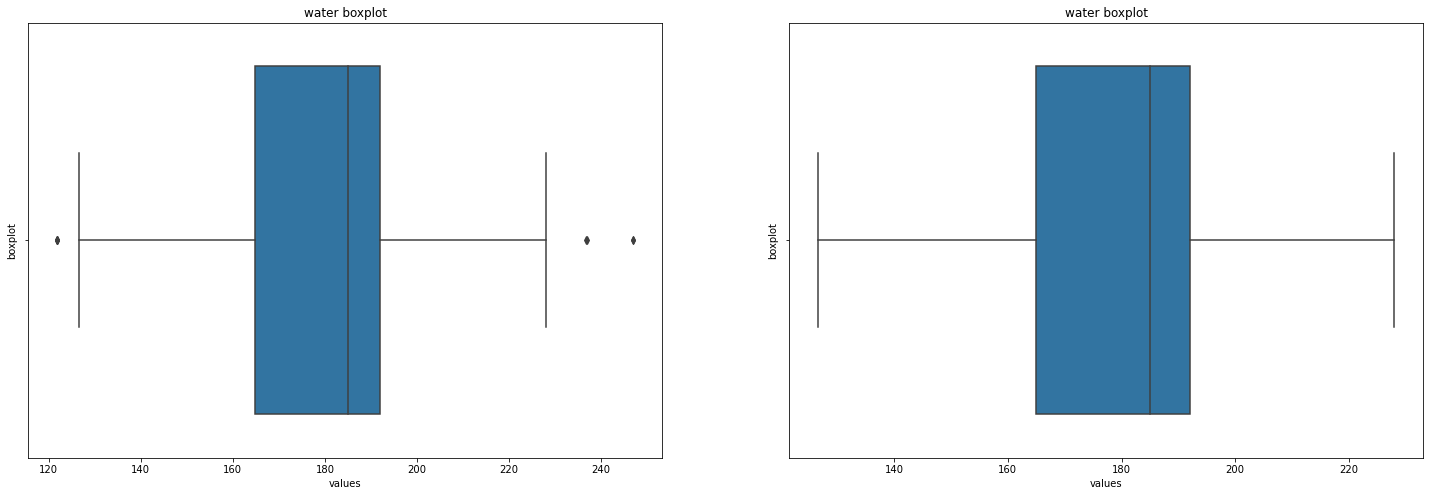

feature superplastic has outliers
total no of outliers in superplastic is 10
outlier percentage in superplastic is 1.0%


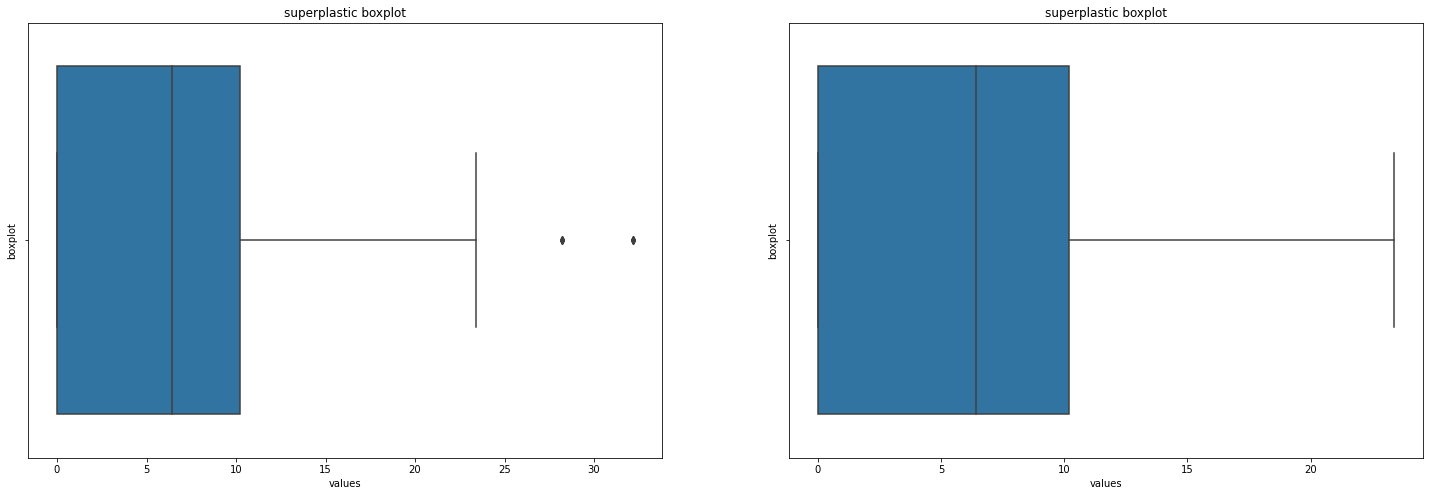

feature coarseagg does not have any outliers


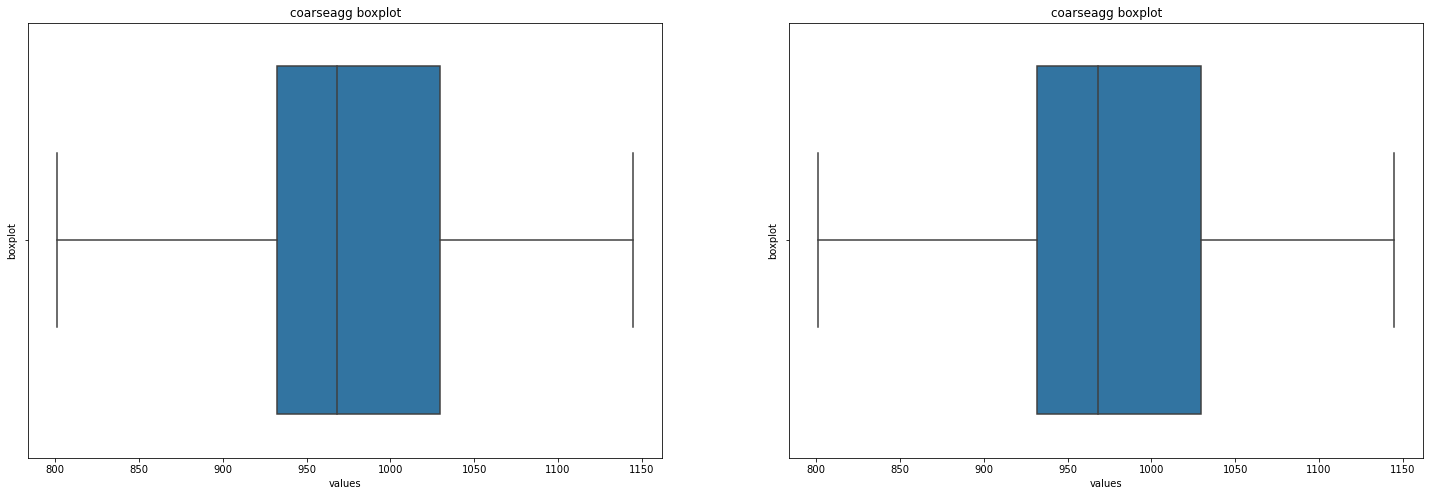

feature fineagg has outliers
total no of outliers in fineagg is 5
outlier percentage in fineagg is 0.0%


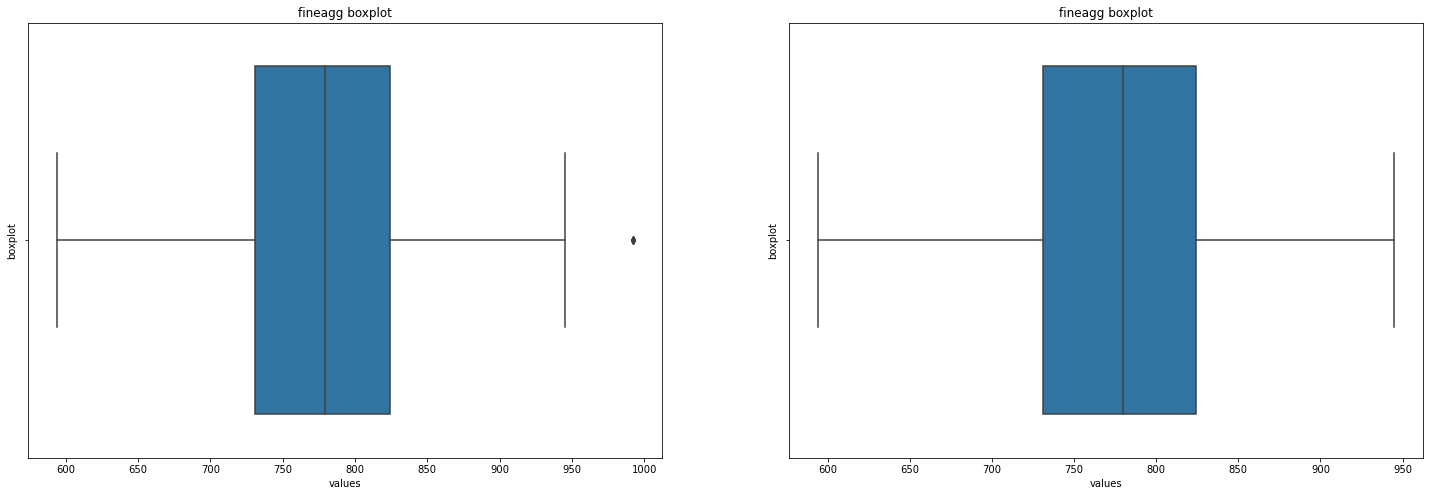

feature age has outliers
total no of outliers in age is 59
outlier percentage in age is 6.0%


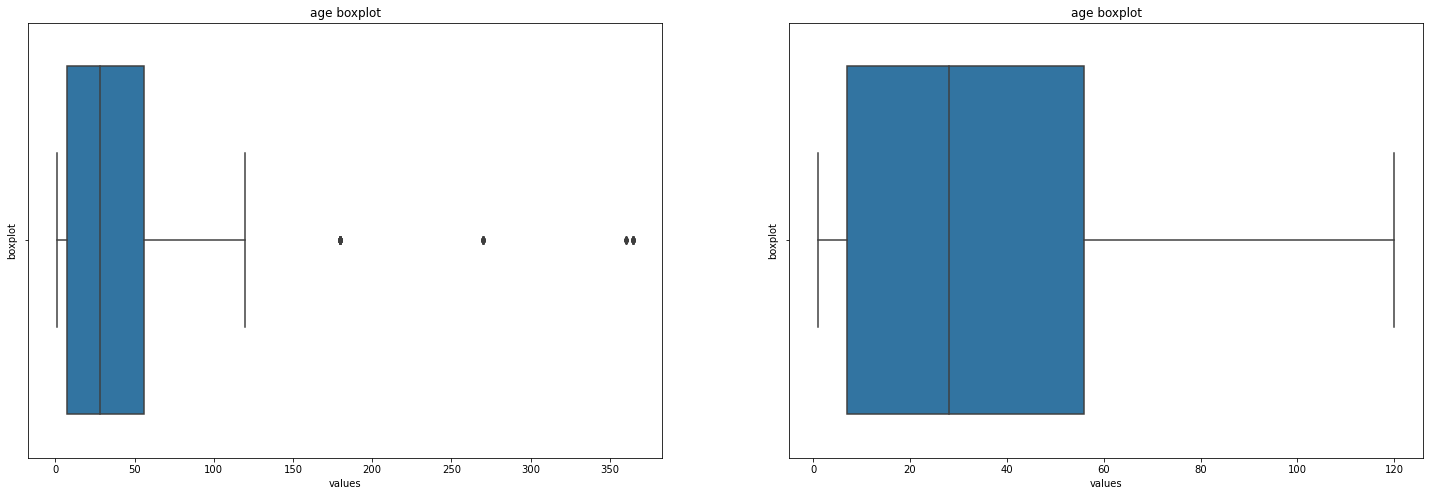

In [10]:
for col in df.drop('strength',axis = 1).columns:
    odt_plots(df,col)

### Multivariate analysis using Regression 

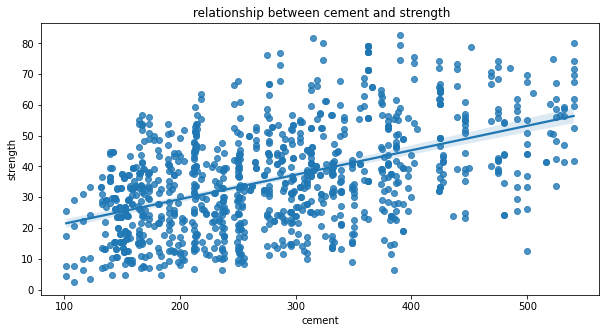

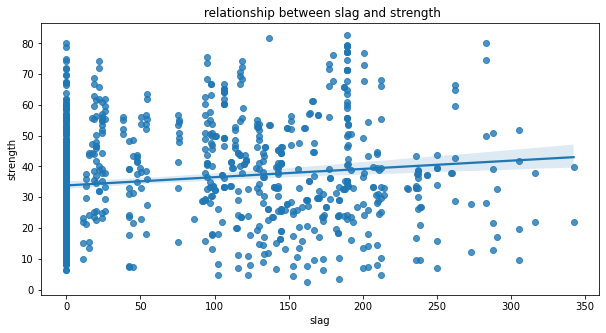

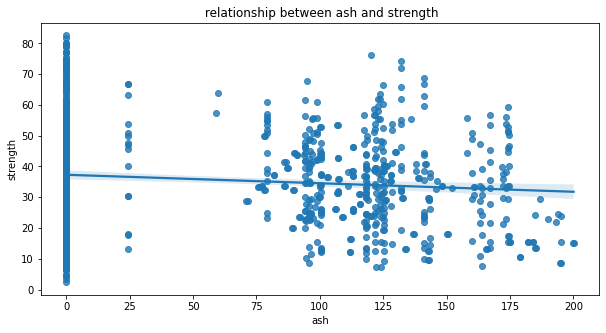

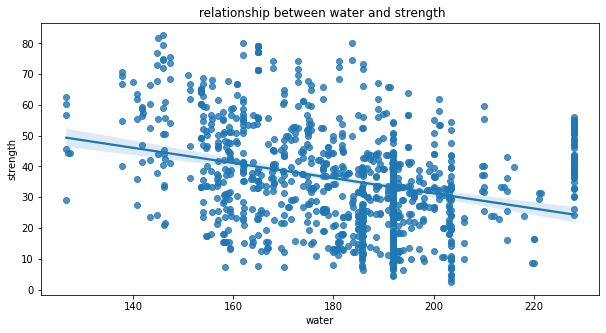

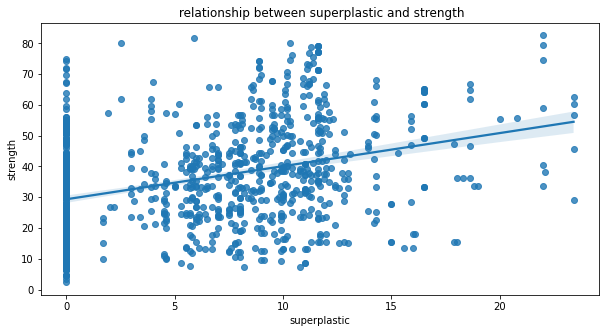

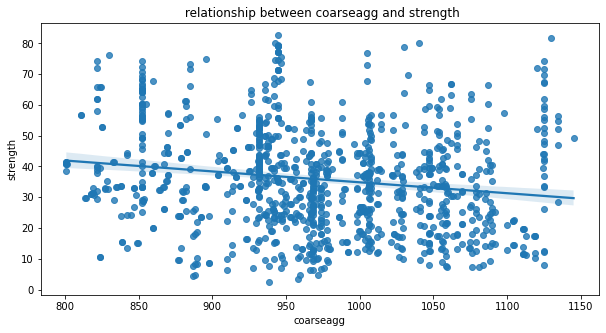

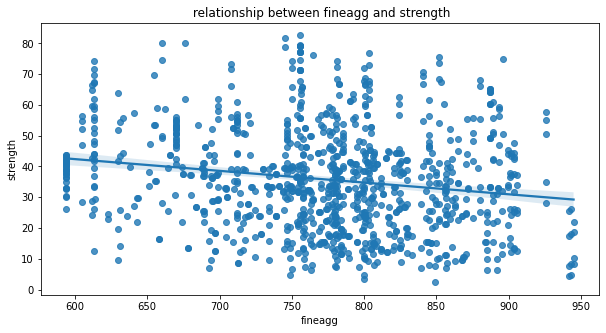

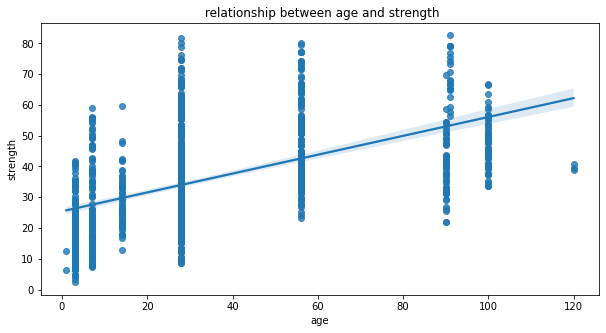

In [11]:
for col in df.columns:
    if col != 'strength':
        fig,ax1 = plt.subplots(figsize=(10,5))
        sns.regplot(x=df[col], y=df['strength'],ax=ax1).set_title(f' relationship between {col} and strength')

 Analysis
1. cement and strength have a strong positive correlation.
2. slag and strength have a mild positive correlation.
3. ash and strength have a mild negative correlation
4. water and strength have a strong negative correlation
5. superplastic and strength have a strong positive correlation
6. coarseagg and strength have a mild negative correlation
7. fineagg and strength have a mild negative correlation
8. age and strength have a strong positive correlation

## Multicollinearity check

Stage 1 - Correlation Heatmap

In [ ]:
# it is not a part of EDA
# it is a part of data preparation

<AxesSubplot:>

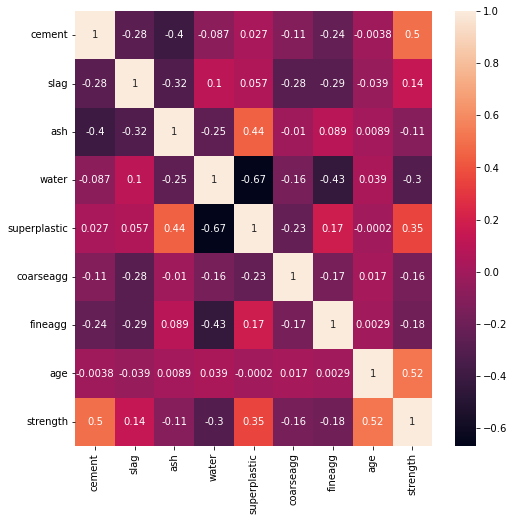

In [12]:
corr = df.corr()
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, annot=True)

Analysis:

independent variables pair with correlation > 30% is listed below.

we should have correlation between independant and depandant variables. so dot consider this. take independant vs independant variable.

1. superplastic and ash are hightly correlated
2. cement and ash
3. slag and ash
4. water and superplastic
5. water and fineagg

many independent features have collinearity > 30% which indicates that there is chance of multicollinearity.

## Multicollinearity 

Stage 2 - Varience Inflating Factor(VIF)

    formula for VIF = 1/ (1-R2)
    
    1. regret every independent variable with each other and find the R2 score
    2. find VIF using above formula
    3. if VIF is more than 5 for any independent variable, we can conclude that the multicollinearity exists.

In [13]:
def VIF(independent_variables):
    vif = pd.DataFrame()
    vif['vif'] = [variance_inflation_factor(independent_variables.values,i) for i in range(independent_variables.shape[1])]
    vif = vif.sort_values('vif',ascending=False)
    vif['independent_variables'] = independent_variables.columns
    return vif

In [14]:
VIF(df.drop('strength',axis=1))

,vif,independent_variables
5,86.535959,cement
3,84.176659,slag
6,70.274934,ash
0,14.826526,water
4,5.980732,superplastic
2,4.486699,coarseagg
1,3.430770,fineagg
7,2.449118,age


Analysis
- cement, water, superplastic,coarseagg and fineagg have VIF score > 5, so we can conculde Multicollinearity exists

## correlation with target features

In [15]:
def CWT(data,tcol):
    independent_variables = data.drop(tcol, axis = 1).columns
    corr_result = []
    for col in independent_variables:
        corr_result.append(data[tcol].corr(data[col]))
    result = pd.DataFrame([independent_variables,corr_result],index= ['independent variables','correlation']).T   # .T will changes rows into columns
    return result.sort_values(by='correlation',ascending = False)

In [16]:
CWT(df,'strength')

,independent variables,correlation
7,age,0.519136
0,cement,0.497832
4,superplastic,0.353588
1,slag,0.137201
2,ash,-0.105755
5,coarseagg,-0.164935
6,fineagg,-0.179536
3,water,-0.304172


Analysis

top 5 highest correlation variables
- age, cement, superplastic, water and fineagg have high correlation with strength.

## Principal Component Analysis (PCA)

In [17]:
def PCA_1(X):
    n_comp = len(X.columns)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
 # applying PCA
    for i in range(1,n_comp):
        pca = PCA(n_components = i)
        p_comp = pca.fit_transform(X)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1] > 0.9:
            n_components = i
            break
    print('explained varience ratio after pca is :' ,evr)
    
 # creating pca dataframe
    col = []
    for j in range(1,n_components + 1):
        col.append('PC_' + str(j))
    pca_df = pd.DataFrame(p_comp,columns=col)
    
    return pca_df
    

In [18]:
np.cumsum([0.9,0.3,0.2])

array([0.9, 1.2, 1.4])

In [19]:
transformed_df = PCA_1(df.drop('strength',axis=1))

explained varience ratio after pca is : [0.27182784 0.44776951 0.61076485 0.73733075 0.86207842 0.97452865]


In [20]:
transformed_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,1.826467,1.284669,-1.306398,-0.071238,-0.534151,-0.790446
1,-1.870787,-0.595629,-1.096613,-1.296651,-0.129022,-0.489721
2,-0.749866,-0.463901,-0.525517,0.698966,-0.783847,0.672137
3,2.776191,0.585938,-0.467626,0.036635,0.034228,0.865712
4,0.907764,0.917339,-0.890205,-1.155748,0.415338,-1.133230
...,...,...,...,...,...,...
1025,-1.731743,0.003980,-1.539754,-0.026398,0.016544,1.020793
1026,-1.615369,-0.132366,3.418087,0.456733,-1.591638,0.297913
1027,-0.505268,1.293797,0.235763,0.108114,0.073852,0.754882
1028,2.694112,-0.308213,0.078722,0.841495,0.734884,1.093212


#### Joining PCA features with Target features

In [21]:
transformed_df = transformed_df.join(df['strength'],how='left')
transformed_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,1.826467,1.284669,-1.306398,-0.071238,-0.534151,-0.790446,29.89
1,-1.870787,-0.595629,-1.096613,-1.296651,-0.129022,-0.489721,23.51
2,-0.749866,-0.463901,-0.525517,0.698966,-0.783847,0.672137,29.22
3,2.776191,0.585938,-0.467626,0.036635,0.034228,0.865712,45.85
4,0.907764,0.917339,-0.890205,-1.155748,0.415338,-1.133230,18.29


## Model Building
- Train test split
- Cross validation
- Hyperparameter tuning

In [22]:
def train_and_test_split(data,t_col,testsize = 0.3):
    X = data.drop(t_col,axis = 1)
    y = data[t_col]
    return train_test_split(X,y,test_size = testsize,random_state = 1)

In [23]:
def model_builder(model_name,estimator,data,t_col):
    x_train,x_test,y_train,y_test = train_and_test_split(data,t_col)
    estimator.fit(x_train,y_train)
    y_pred = estimator.predict(x_test)
    accuracy = r2_score(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    return [model_name,accuracy,rmse]

In [24]:
model_builder(model_name = 'Linear regression',estimator = LinearRegression(),data = transformed_df,t_col='strength')

['Linear regression', 0.7044000711171952, 9.275304466382536]

In [25]:
def multiple_models(data,t_col):
    col_names = ['Model Name','R2 Score','RMSE']
    result = pd.DataFrame(columns=col_names)
    result.loc[len(result)] = model_builder('LinearRegression',LinearRegression(),data,t_col)
    result.loc[len(result)] = model_builder('Decision Tree Regressor',DecisionTreeRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Lasso',Lasso(),data,t_col)
    result.loc[len(result)] = model_builder('Ridge',Ridge(),data,t_col)
    result.loc[len(result)] = model_builder('K Neighbour Regressor',KNeighborsRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('SVR',SVR(),data,t_col)
    result.loc[len(result)] = model_builder('Random Forest Regressor',RandomForestRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Ada Boost Regressor',AdaBoostRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Gradient Boosting Regressor',GradientBoostingRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('XGradient Boosting Regressor',XGBRegressor(),data,t_col)
    
    return result.sort_values(by='R2 Score',ascending = False)

In [26]:
multiple_models(transformed_df,'strength')

,Model Name,R2 Score,RMSE
9,XGradient Boosting Regressor,0.860129,6.380286
6,Random Forest Regressor,0.847315,6.666145
8,Gradient Boosting Regressor,0.823174,7.173797
4,K Neighbour Regressor,0.796457,7.696695
1,Decision Tree Regressor,0.714890,9.109246
5,SVR,0.711303,9.166357
7,Ada Boost Regressor,0.706382,9.244163
3,Ridge,0.704407,9.275192
0,LinearRegression,0.704400,9.275304
2,Lasso,0.697520,9.382628


### Cross Validation

In [27]:
def kfoldCV(x,y,fold = 10):
    score_lr = cross_val_score(LinearRegression(),x,y,cv = fold)
    score_las = cross_val_score(Lasso(),x,y,cv= fold)
    score_Rf = cross_val_score(RandomForestRegressor(),x,y,cv= fold)
    score_Rid = cross_val_score(Ridge(),x,y,cv= fold)
    score_Dt = cross_val_score(DecisionTreeRegressor(),x,y,cv= fold)
    score_Svr = cross_val_score(SVR(),x,y,cv= fold)
    score_Abr = cross_val_score(AdaBoostRegressor(),x,y,cv= fold)
    score_Knr = cross_val_score(KNeighborsRegressor(),x,y,cv= fold)
    score_Gbr = cross_val_score(GradientBoostingRegressor(),x,y,cv= fold)
    score_Xgbr = cross_val_score(XGBRegressor(),x,y,cv= fold)
        
    model_names = ['LinearRegression','Lasso','Random forest','Ridge','Decision tree','Svr','Ada Boost Regressor','K Neighbour Regressor','Gradient Boosting Regressor','XGradient Boosting Regressor']
    scores = [score_lr,score_las,score_Rf,score_Rid,score_Dt,score_Svr,score_Abr,score_Knr,score_Gbr,score_Xgbr]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names,score_mean,score_std]
        result.append(temp)
    kfold_df = pd.DataFrame(result,columns=['Model Name','CV Score','CV std']).sort_values(by='CV Score',ascending=False)
        
    return kfold_df
    

In [28]:
kfoldCV(transformed_df.drop('strength',axis= 1),transformed_df['strength'])

,Model Name,CV Score,CV std
9,XGradient Boosting Regressor,0.881777,0.029919
2,Random forest,0.867143,0.033396
8,Gradient Boosting Regressor,0.825915,0.030334
7,K Neighbour Regressor,0.799934,0.031273
4,Decision tree,0.766158,0.055506
5,Svr,0.725758,0.040625
3,Ridge,0.706597,0.046574
0,LinearRegression,0.706585,0.046654
6,Ada Boost Regressor,0.697586,0.047488
1,Lasso,0.689706,0.036669


In [29]:
kfoldCV(transformed_df.drop('strength',axis= 1),transformed_df['strength']).reset_index(drop = True)

,Model Name,CV Score,CV std
0,XGradient Boosting Regressor,0.881777,0.029919
1,Random forest,0.866058,0.036614
2,Gradient Boosting Regressor,0.826017,0.030185
3,K Neighbour Regressor,0.799934,0.031273
4,Decision tree,0.755556,0.054492
5,Svr,0.725758,0.040625
6,Ridge,0.706597,0.046574
7,LinearRegression,0.706585,0.046654
8,Ada Boost Regressor,0.705949,0.039703
9,Lasso,0.689706,0.036669


### Hyper parameter Tuning

In [ ]:
# we wont try to tune every model, because if we tune last placed model it will increase the accuracy by 10 percent max,
# but if try to tune top models, we can go beyond 90 percent accuracy. 

In [30]:
def tuning(x,y,fold = 10):
    # parameter grids for different models
    # parameter grid is nothing but a dictionary, it contains a list of hyperparameters that we want to tune for particular model.
    
    #param_las = {'alpha': [1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    #param_rd = {'alpha': [1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    #param_dtr = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error','poisson'],'max_depth':[3,5,7,9],'max_features':[1,2,3,4,5,6,7,'auto','log2','sqrt']}   
    # decision tree when it grows to level of 11 in max_depth, it is very big number for tree as it will learn so much as there will be a chance to overfit
    # in max_features we write upto 7, not 8 because it will then take all the features/column. we dont want to do that because it will automatically done by auto
    #param_knn = {'weights': ['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree','brute']}
    #param_svr = {'gamma':['scale','auto'],'C':[0.1,1,1.5,20]}
    param_rf = {'max_depth':[3,5,7,9,1],'max_features':[1,2,3,4,5,6,7,'auto','log2','sqrt'],'n_estimators':[50,100,150]} 
    # n_estimators are week learners
    #param_adb = {'n_estimators':[50,100,150,200],'learning_rate':[0.1,0.5,0.7,1,5,10,20,50,100],'loss':['linear','square','exponential']}
    #param_gb = {'n_estimators':[50,100,150,200],'learning_rate':[0.1,0.5,0.7,1,5,10,20,50,100],'loss':['squared_error','absolute_error','huber','quantile']}
    param_xgb = {'eta':[0.1,0.5,0.7,1,5,10,20],'max_depth':[3,5,7,9],'gamma':[0,10,20,50],'lambda':[0,1,3,5,7],'alpha':[0,1,3,5,7]}
    
    # creating model object
    # for every model,we have created a grid and we have to now create a model
    
    #tune_las = GridSearchCV(Lasso(),param_las,cv=fold)
    #tune_rd = GridSearchCV(Ridge(),param_rd,cv=fold)
    #tune_dtr = GridSearchCV(DecisionTreeRegressor(),param_dtr,cv=fold)
    #tune_knn = GridSearchCV(KNeighborsRegressor(),param_knn,cv=fold)
    #tune_svr = GridSearchCV(SVR(),param_svr,cv=fold)
    tune_rf = GridSearchCV(RandomForestRegressor(),param_rf,cv=fold)
    #tune_adb = GridSearchCV(AdaBoostRegressor(),param_adb,cv=fold)
    #tune_gb = GridSearchCV(GradientBoostingRegressor(),param_gb,cv=fold)
    tune_xgb = GridSearchCV(XGBRegressor(),param_xgb,cv=fold)
    
    # model fitting
    #tune_las.fit(x,y)
    #tune_rd.fit(x,y)
    #tune_dtr.fit(x,y)
    #tune_knn.fit(x,y)
    #tune_svr.fit(x,y)
    tune_rf.fit(x,y)
    #tune_adb.fit(x,y)
    #tune_gb.fit(x,y)
    tune_xgb.fit(x,y)
    
    tune = [tune_rf,tune_xgb]
    models = ['RF','XGB']
    
    for i in range(len(tune)):
        print('model:',models[i])
        print('Best_params:',tune[i].best_params_)
        

In [31]:
tuning(transformed_df.drop('strength',axis=1),transformed_df['strength'])

model: RF
Best_params: {'max_depth': 9, 'max_features': 6, 'n_estimators': 150}
model: XGB
Best_params: {'alpha': 7, 'eta': 0.1, 'gamma': 0, 'lambda': 1, 'max_depth': 7}


In [100]:
def cv_post_hpt(x,y,fold=10):
    # cross validation post hyperparameter tuning
    # what ever best values we get above,we will use them and find the updated accuracy/r2 score for those models
    
    score_lr = cross_val_score(LinearRegression(),x,y,cv = fold)
    # we have not tuned for linear regression
    #score_las = cross_val_score(Lasso(alpha = ),x,y,cv= fold)
    score_Rf = cross_val_score(RandomForestRegressor(max_depth=9,max_features=3,n_estimators=150),x,y,cv= fold)
    #score_Rid = cross_val_score(Ridge(alpha = ),x,y,cv= fold)
    #score_Dt = cross_val_score(DecisionTreeRegressor(max_depth = ,max_features=,criterion=),x,y,cv= fold)
    #score_Svr = cross_val_score(SVR(gamma=,c=),x,y,cv= fold)
    #score_Abr = cross_val_score(AdaBoostRegressor(n_estimators=,learning_rate=,loss=),x,y,cv= fold)
    #score_Knr = cross_val_score(KNeighborsRegressor(weights=,algorithm=),x,y,cv= fold)
    #score_Gbr = cross_val_score(GradientBoostingRegressor(n_estimators=,learning_rate=,loss=),x,y,cv= fold)
    score_Xgbr = cross_val_score(XGBRegressor(eta=0.1,max_depth=7,gamma=0,reg_lambda=1,alpha=7),x,y,cv= fold)
        
    model_names = ['Random forest','XGradient Boosting Regressor']
    scores = [score_Rf,score_Xgbr]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names,score_mean,score_std]
        result.append(temp)
    kfold_df = pd.DataFrame(result,columns=['Model Name','CV Score','CV std'])
    
    return kfold_df.sort_values(by='CV Score',ascending=False)

In [43]:
cv_post_hpt(transformed_df.drop('strength',axis=1),transformed_df['strength'])

,Model Name,CV Score,CV std
1,XGradient Boosting Regressor,0.892237,0.020964
0,Random forest,0.854396,0.035256


## Clustering:

- using clustering to check if it can help us improve the accuracy

<AxesSubplot:xlabel='cement', ylabel='strength'>

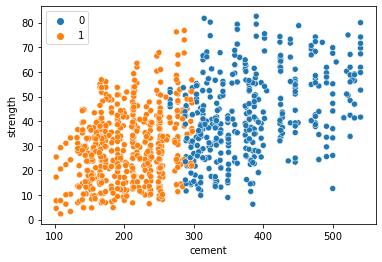

In [47]:
labels = KMeans(n_clusters = 2, random_state=2)
clusters = labels.fit_predict(df.drop('strength',axis=1))
sns.scatterplot(x = df['cement'], y= df['strength'], hue=clusters)

In [60]:
def clustering(x,tcol,cluster):
    column = list(set(list(x.columns)) - set(list('strength')))
    #column = list(x.columns)
    r = int(len(column)/2)
    if len(column) % 2 == 0:
        r = r
    else:
        r += 1
    f,ax = plt.subplots(r,2,figsize = (15,15))
    a = 0
    for row in range(r):
        for col in range(2):
            if a != len(column):
                ax[row][col].scatter(x[tcol],x[column[a]],c = cluster)
                ax[row][col].set_xlabel(tcol)
                ax[row][col].set_ylabel(column[a])
                a += 1

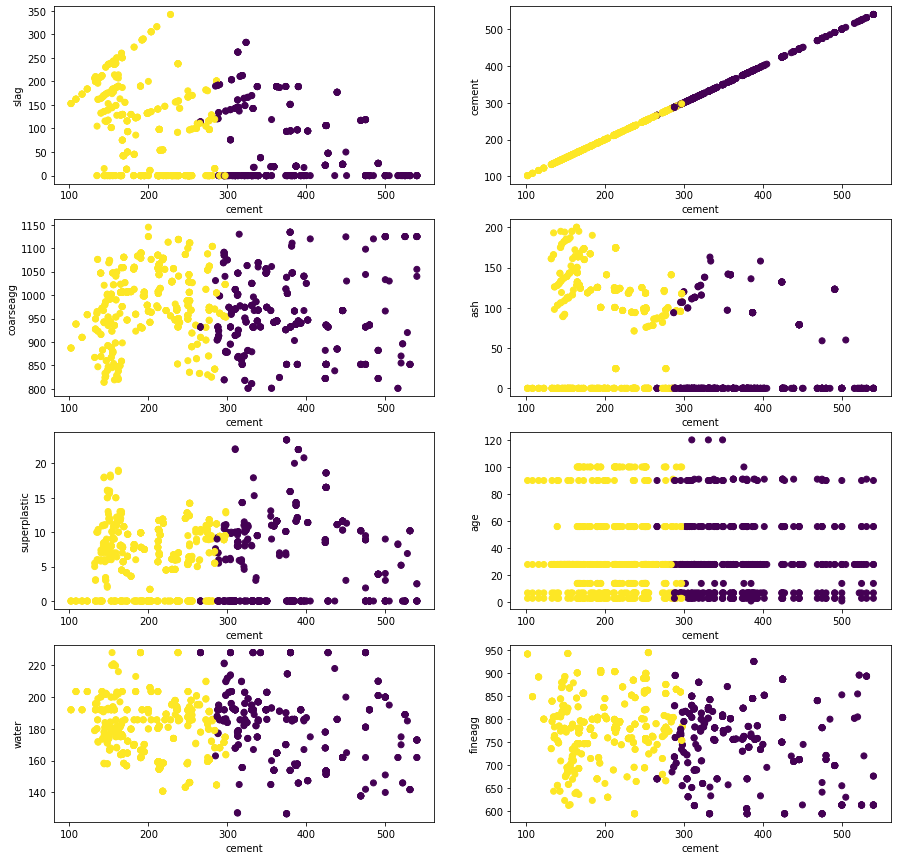

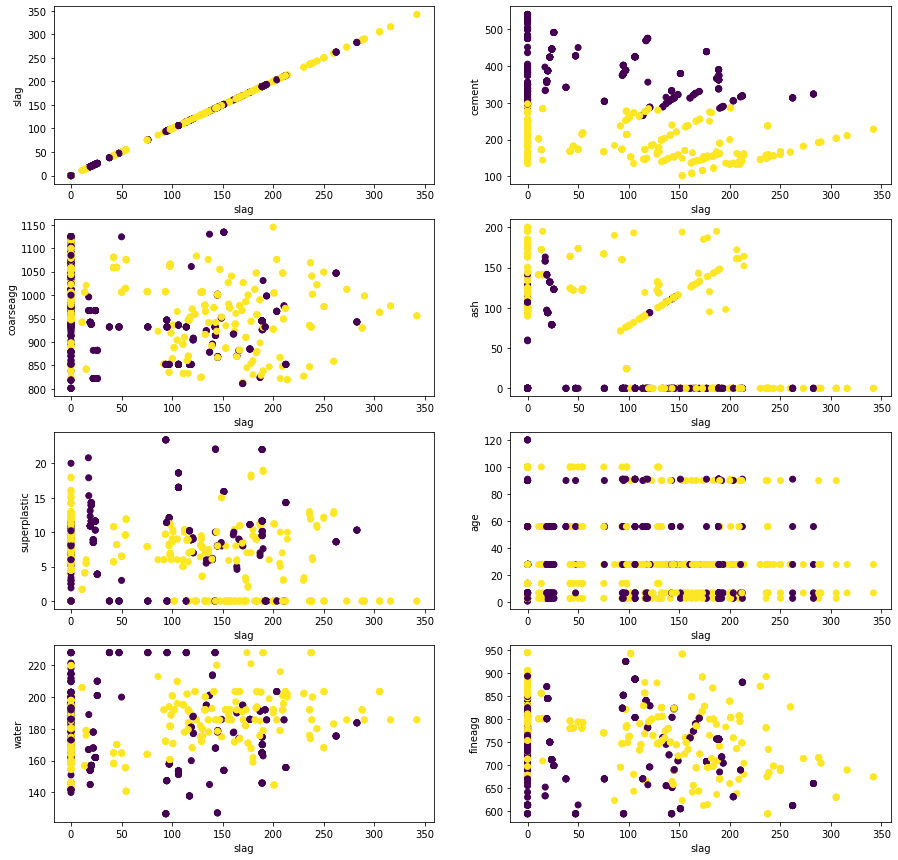

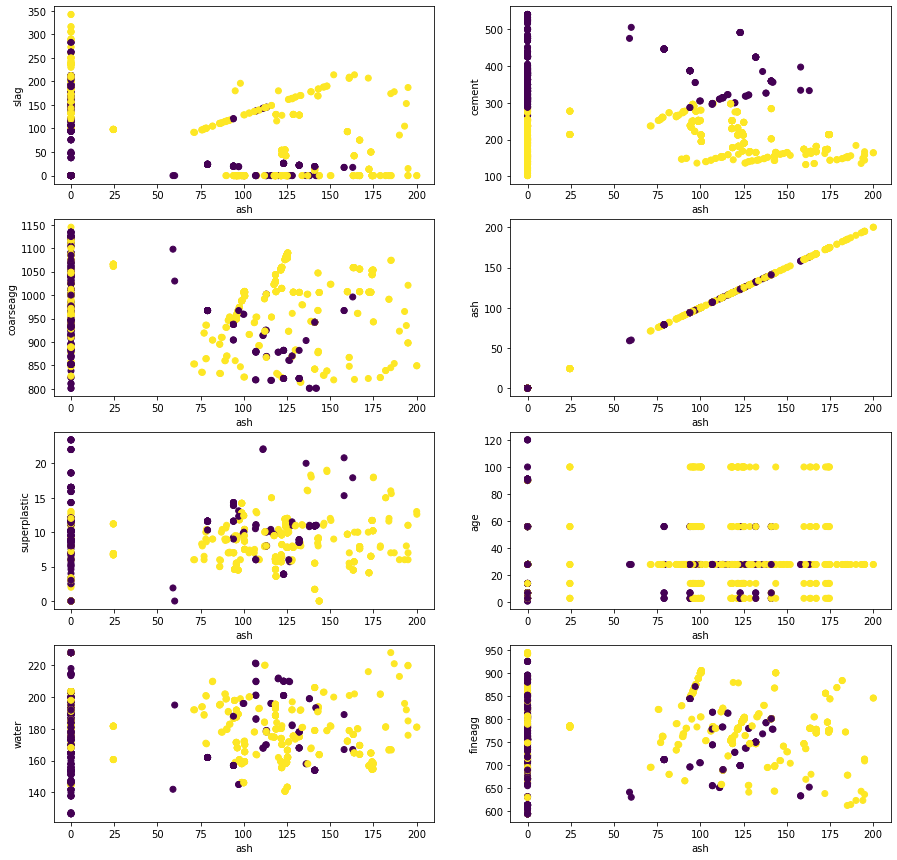

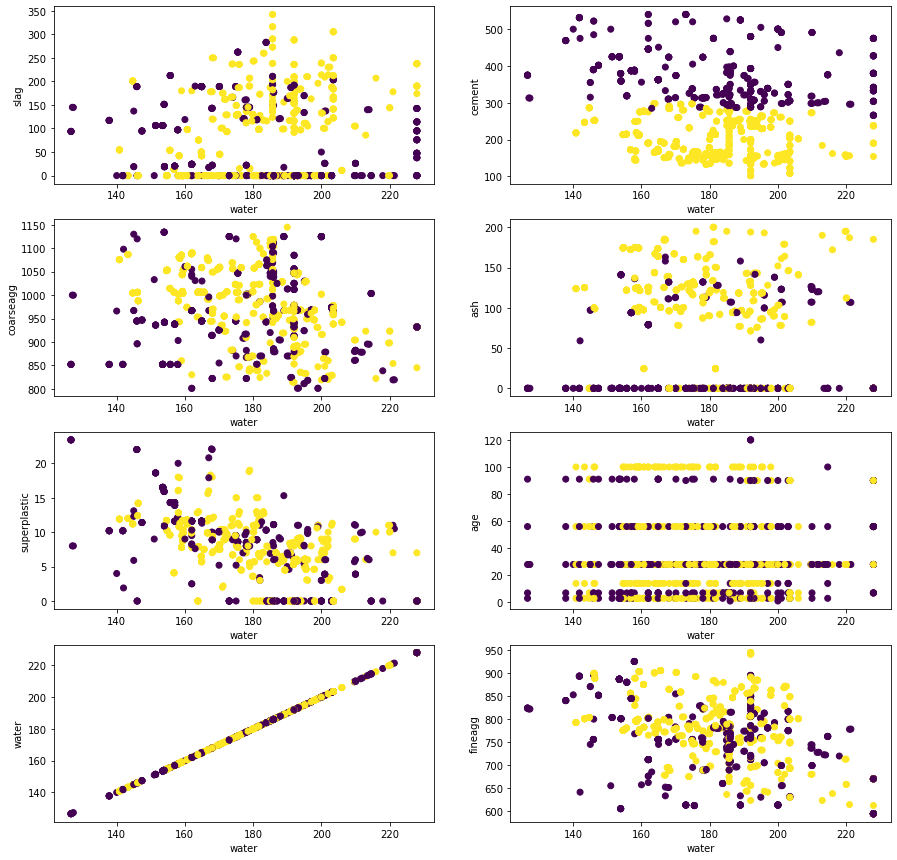

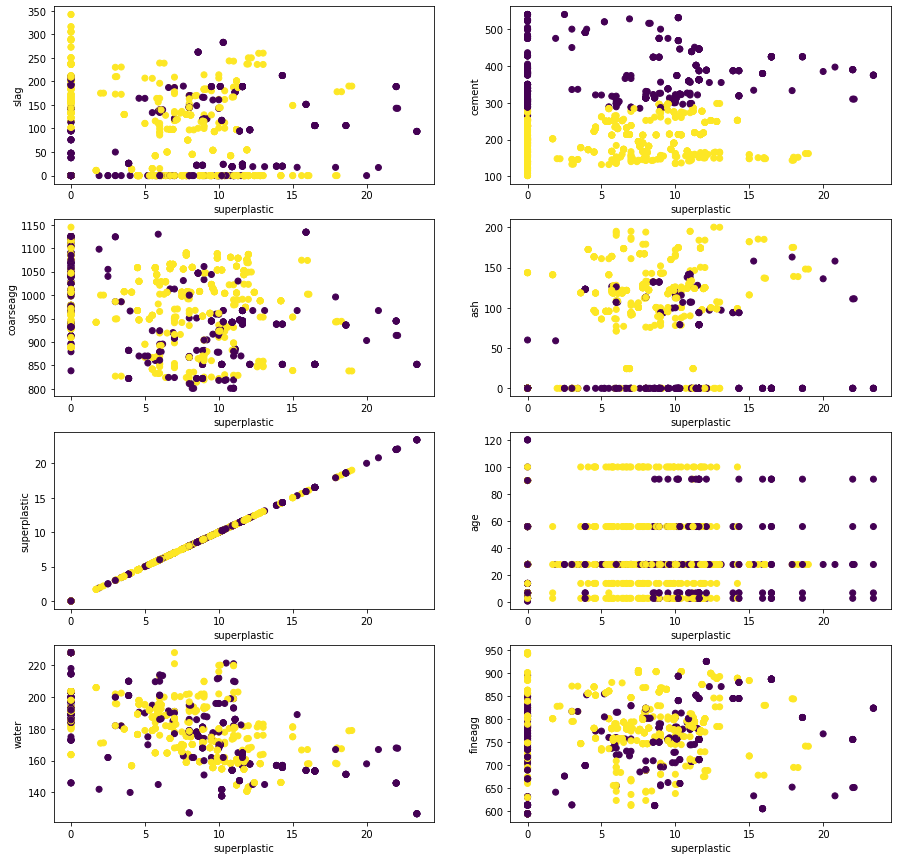

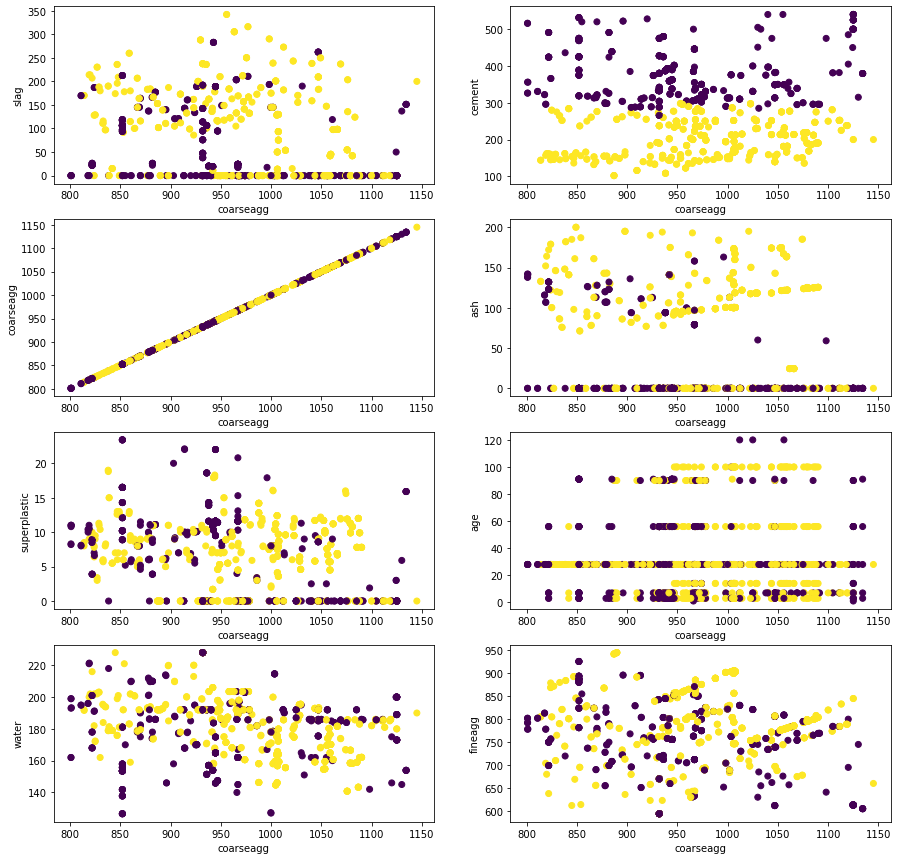

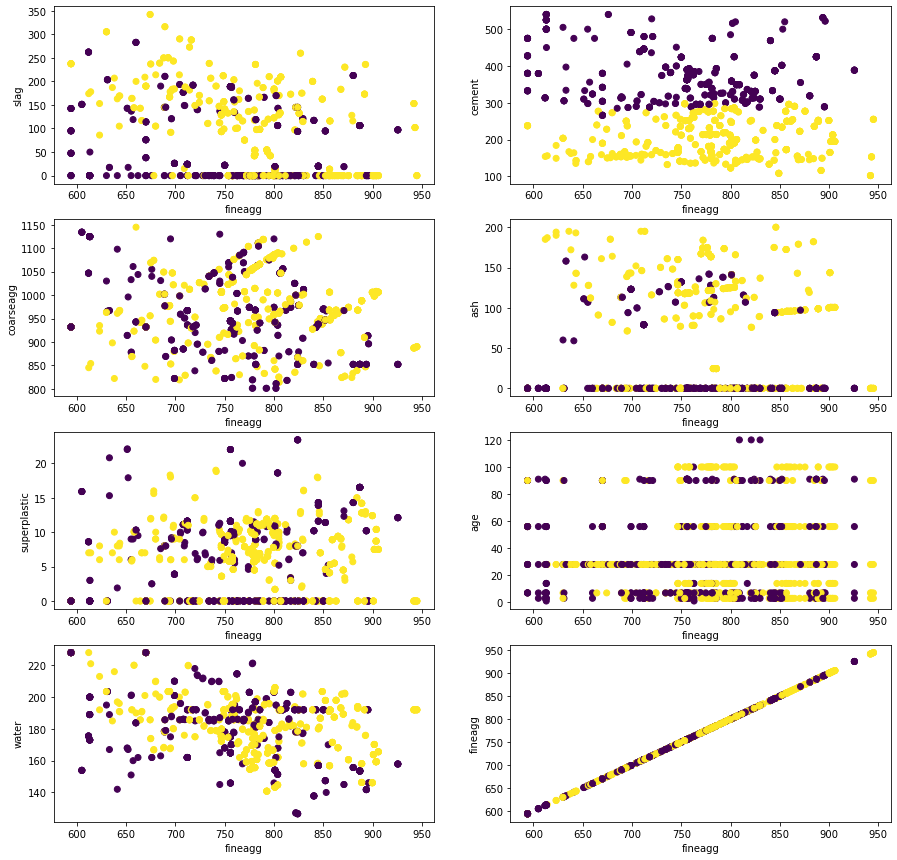

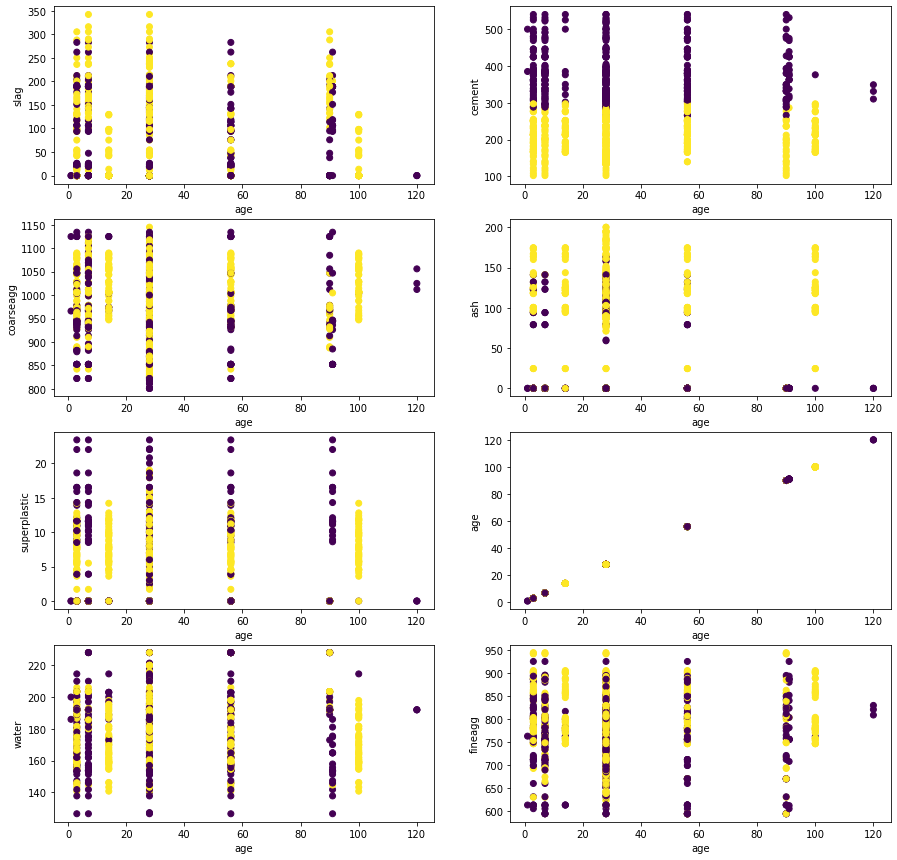

In [61]:
x = df.drop('strength', axis= 1)
for col in x.columns:
    clustering(x,col,clusters)

Analysis
- cement is forming clear clusters with all the other independent variables

In [62]:
new_df = df.join(pd.DataFrame(clusters,columns=['cluster']),how = 'left')

In [63]:
clusters

array([1, 1, 1, ..., 1, 0, 0])

In [64]:
list(clusters)

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,


In [75]:
# these are the datapoints in which the cluster belongs to
# we have merged this list with our dataframe and saved the output in our new_df

In [74]:
new_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cluster
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1
...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,1
1026,531.3,0.0,0.0,141.8,10.2,852.1,893.7,3,41.30,0
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,1
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,56,55.06,0


In [78]:
new_f = new_df.groupby('cluster')['cement'].agg(['mean','median'])

In [79]:
new_f

,mean,median
cluster,,
0,378.191685,362.6
1,203.785864,202.0


In [80]:
# after merging the list, we are taking groupby for 0th and 1st cluster and extracted cement column and found mean and median for that.
# we are doing this because 0 and 1 are not in same range with the dataframe, they are different. so it may be very far away with other points. so we are taking mean and median values for that 

In [82]:
cluster_df = new_df.merge(new_f, on = 'cluster', how = 'left')
cluster_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cluster,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1,203.785864,202.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1,203.785864,202.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1,203.785864,202.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0,378.191685,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1,203.785864,202.0


In [ ]:
# we added 2 more columns in dataframe
# lets try to see what is the improvement in the accuracy of the model after using this.

#### model evaluation on clustered dataframe

In [83]:
multiple_models(cluster_df,'strength')

,Model Name,R2 Score,RMSE
9,XGradient Boosting Regressor,0.913379,5.020959
6,Random Forest Regressor,0.904035,5.284850
8,Gradient Boosting Regressor,0.899082,5.419524
1,Decision Tree Regressor,0.870649,6.135654
7,Ada Boost Regressor,0.778543,8.028239
2,Lasso,0.738715,8.720340
0,LinearRegression,0.738120,8.730254
3,Ridge,0.738103,8.730540
4,K Neighbour Regressor,0.704762,9.269623
5,SVR,0.224695,15.021466


In [84]:
# compare this with previous accuracy

In [85]:
kfoldCV(cluster_df.drop('strength',axis=1),cluster_df['strength'])

,Model Name,CV Score,CV std
9,XGradient Boosting Regressor,0.934372,0.019028
2,Random forest,0.917732,0.024512
8,Gradient Boosting Regressor,0.902905,0.019831
4,Decision tree,0.877800,0.043293
6,Ada Boost Regressor,0.785777,0.026669
3,Ridge,0.736353,0.035023
0,LinearRegression,0.736313,0.034928
1,Lasso,0.736257,0.034576
7,K Neighbour Regressor,0.697235,0.060626
5,Svr,0.244477,0.045366


In [88]:
# there is a significant improvement in accuracy when using clustering .
# it is a good decision to use clustering
# every time clustering will not help, its just like trail method to check it out

In [87]:
cv_post_hpt(cluster_df.drop('strength',axis=1),cluster_df['strength'])

,Model Name,CV Score,CV std
1,XGradient Boosting Regressor,0.934037,0.021075
0,Random forest,0.910143,0.021993


## Feature Importance

In [90]:
x_train,x_test,y_train,y_test = train_and_test_split(cluster_df,'strength')
# data = cluster_df, tcol = strength

In [95]:
x_train

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,cluster,mean,median
185,350.0,0.0,0.0,203.0,0.0,974.0,775.0,14,0,378.191685,362.6
286,374.0,189.2,0.0,170.1,10.1,926.1,756.7,91,0,378.191685,362.6
600,277.0,0.0,0.0,191.0,0.0,968.0,856.0,3,1,203.785864,202.0
691,380.0,95.0,0.0,228.0,0.0,932.0,594.0,7,0,378.191685,362.6
474,356.0,0.0,142.0,193.0,11.0,801.0,778.0,28,0,378.191685,362.6
...,...,...,...,...,...,...,...,...,...,...,...
960,251.8,0.0,99.9,146.1,12.4,1006.0,899.8,3,1,203.785864,202.0
847,165.0,0.0,143.6,163.8,0.0,1005.6,900.9,3,1,203.785864,202.0
715,303.6,139.9,0.0,213.5,6.2,895.5,722.5,28,0,378.191685,362.6
905,318.0,0.0,126.0,210.0,6.0,861.0,737.0,28,0,378.191685,362.6


In [91]:
xgb = XGBRegressor()
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [92]:
# we are seeing above, all the hyperparameters that xgb uses. some are normal parameters

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

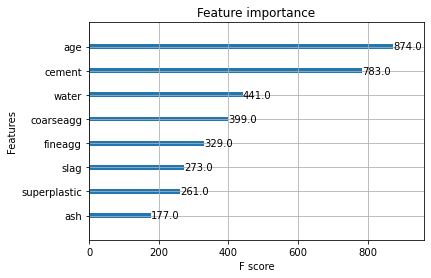

In [93]:
xgboost.plot_importance(xgb)

In [94]:
# we have score for every features(f score)
# i.e fish test significance score. it is a statistical test
# mean,median values are not seen as it may be very small values
# we are picking features > 300

In [98]:
subset_df = cluster_df[['age','cement','water','coarseagg','fineagg','strength']]

In [101]:
cv_post_hpt(subset_df.drop('strength',axis=1),subset_df['strength'])

,Model Name,CV Score,CV std
1,XGradient Boosting Regressor,0.912672,0.022350
0,Random forest,0.876317,0.026985


In [ ]:
# considering the percentage of droping data vs percentage of drop in accuracy, it was a good trade
# removing 50% of features and giving nearly same result in cv with 1% less only, so its a good use.

## Recursive feature elimination (RFE)

In [131]:
rfe = RFE(estimator = XGBRegressor())

In [132]:
rfe_df = cluster_df

In [133]:
rfe.fit(rfe_df.drop('strength',axis=1),rfe_df['strength'])

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, early_stopping_rounds=None,
                           enable_categorical=False, eval_metric=None,
                           gamma=None, gpu_id=None, grow_policy=None,
                           importance_type=None, interaction_constraints=None,
                           learning_rate=None, max_bin=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None, predictor=None,
                           random_state=None, reg_alpha=None, reg_lambda=None, ...))

In [134]:
rfe.support_

array([ True,  True, False, False,  True, False, False,  True,  True,
       False, False])

In [135]:
rfe_df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength', 'cluster', 'mean', 'median'],
      dtype='object')

In [136]:
final_df = cluster_df[['cement', 'slag','superplastic','age','strength']]

In [137]:
cv_post_hpt(final_df.drop('strength',axis=1),final_df['strength'])

,Model Name,CV Score,CV std
1,XGradient Boosting Regressor,0.912594,0.025461
0,Random forest,0.889080,0.028668


## Learning curve analysis

In [102]:
# last step in data science project
# will be in simple graphical format so that one can understand what have been done in this project and how models functioning

In [107]:
def generate_learning_curve(model_name,estimator,x,y):
    train_size,train_score,test_score = learning_curve(estimator,x,y,cv=10)
#     print('train_size',train_size)
#     print('train_score',train_score)
#     print('test_score',test_score)
    train_score_mean = np.mean(train_score,axis=1)
    test_score_mean = np.mean(test_score,axis=1)
    plt.plot(train_size,train_score_mean,c='blue')
    plt.plot(train_size,test_score_mean,c='red')
    plt.xlabel('samples')
    plt.ylabel('scores')
    plt.title('learning curve for '+ model_name)
    plt.legend(('Training accuracy ','Testing accuracy'))

In [ ]:
# for the linear regression model, it as taken 92 dataset from samples, around 10%. so we have 10 different accuracy.
# randomly generated samples, we have 3 output here. performed 10 fold cv.
# it helps us in, how many samples u need to get the max possible accuracy from the sample.

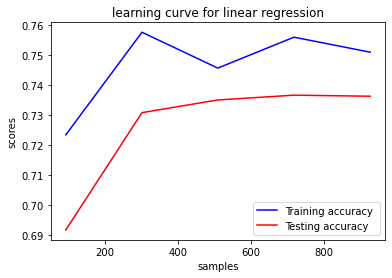

In [108]:
generate_learning_curve('linear regression', LinearRegression(),cluster_df.drop('strength',axis=1),cluster_df['strength'])

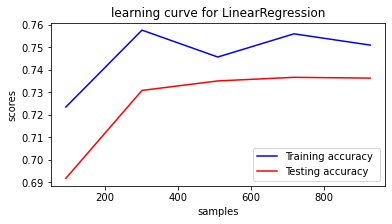

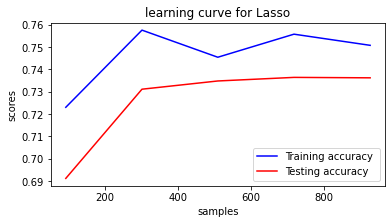

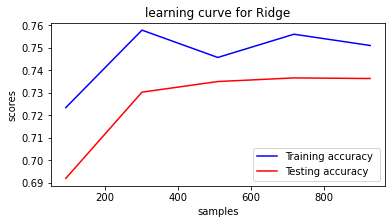

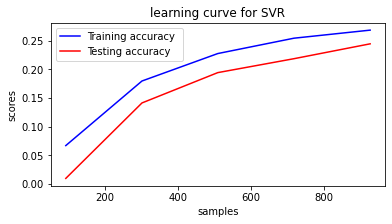

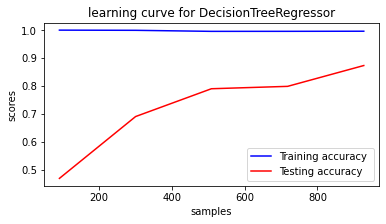

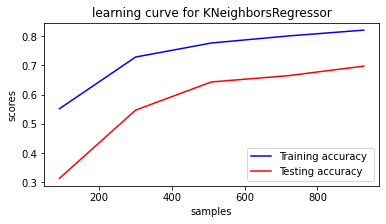

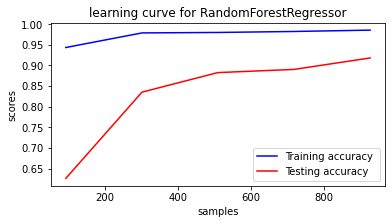

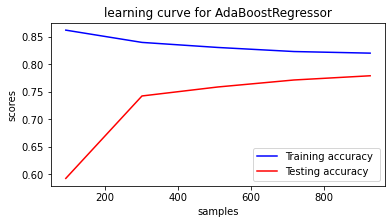

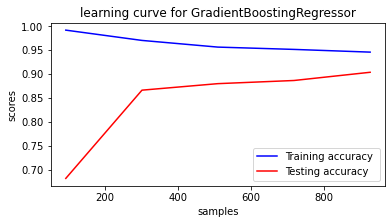

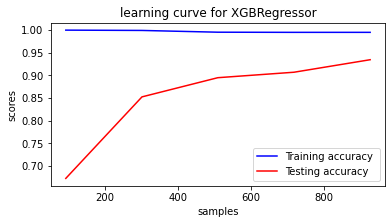

In [109]:
model_names = [LinearRegression(),Lasso(),Ridge(),SVR(),DecisionTreeRegressor(),KNeighborsRegressor(),
               RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]
for i,model in enumerate(model_names):
    #print(i)
    #print(model)
    
    fg = plt.figure(figsize = (6,3))
    ax = fig.add_subplot(5,2,i+1)
    generate_learning_curve(type(model).__name__,model,cluster_df.drop('strength',axis=1),cluster_df['strength'])

# Model prediction for unseen data

In [110]:
x_train,x_test,y_train,y_test = train_and_test_split(cluster_df,'strength',testsize=0.1)
# data-cluster_df,tcol-strength,trainsize-0.9
model = XGBRegressor()
model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [111]:
x_train.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,cluster,mean,median
90,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,7,1,203.785864,202.0
711,287.3,120.5,93.9,187.6,9.2,904.4,695.9,28,0,378.191685,362.6
675,230.0,0.0,118.3,195.5,4.6,1029.4,758.6,14,1,203.785864,202.0
241,427.5,47.5,0.0,228.0,0.0,932.0,594.0,90,0,378.191685,362.6
698,252.5,0.0,0.0,185.7,0.0,1111.6,784.3,7,1,203.785864,202.0


In [112]:
# until age, user will provide data.
# for cluster,we have to predict using kmeans model

In [113]:
test_data = [[270,80,100,180,0,800,800,90]]
# this is the test data
# we want to find cluster information for this

In [116]:
 labels.predict(test_data)
# this will say, in which cluster it will be belonging

array([1])

In [117]:
test_data = [[270,80,100,180,0,800,800,90,1,203.785864,202.0]]
# this is what the preprocessing we need to do on test data. these are manual ones

In [120]:
model.predict(pd.DataFrame(test_data,columns=x_train.columns))

array([49.78918], dtype=float32)

In [ ]:
# this is the prediction of the final strength

In [121]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [125]:
test_data_1 = [[141,212,0,203,0,971,748,28,1,203.785864,202.0]]

In [124]:
labels.predict(test_data_1)

array([1])

In [126]:
model.predict(pd.DataFrame(test_data_1,columns=x_train.columns))

array([30.534746], dtype=float32)

In [127]:
# comparing the prediction with same data and getting same output with actual value